# The Twiddle Algorithm: A Parameter Optimization Heuristic

**Description**: Twiddle is an algorithm that tries to find a good choice of parameters *p* for an algorithm *A* (must return an error).

In [1]:
# =============================================================================
# IMPORT LIBRARIES
# =============================================================================
import importlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# =============================================================================
# USER DEFINED FUNCTIONS
# =============================================================================
# The Twiddle optimization algorithm
def twiddle(algorithm, initial_params, non_optimized_params, potential_changes, threshold, verbose = True, plot_err = True):
    if threshold >= sum(potential_changes):
        print("ERROR: Threshold is too large. The threshold must be < sum(potential_changes).")
    else:
        params = initial_params
        
        # Calculate initial error
        params_str = ','.join([str(i) for i in params])
        non_optimized_params_str = ','.join([f'non_optimized_params[{i}]' for i, object in enumerate(non_optimized_params)])
        initial_err = eval(f"algorithm({non_optimized_params_str},{params_str})")
        print(f'Initial error is: {initial_err}')
        
        # Instantiate a few variables
        best_err = initial_err
        results_lst = []
        
        
        while sum(potential_changes) > threshold:
            for i in range(len(params)):
                # Tweak parameters by one potential change/jump in the positive direction
                params[i] += potential_changes[i]
                
                # Calculate the error that results from running the algorithm with the tweaked parameters
                params_str = ','.join([str(i) for i in params])
                non_optimized_params_str = ','.join([f'non_optimized_params[{i}]' for i, object in enumerate(non_optimized_params)])
                err = eval(f"algorithm({non_optimized_params_str},{params_str})")
                
                # Store the parameters used & results from the algorithm run
                eval(f"results_lst.append([{params_str},err])")
                
                if verbose:
                    # Provide status update
                    print(f'   → Tweak #: {len(results_lst) - 1} | Tweaking Param #: {i} | Sum PC: {sum(potential_changes)} | Error: {err} | Params: {params}')
                
                # If there was some improvement
                if err < best_err: 
                    # Note the new best error
                    best_err = err
                    
                    # Modulate the change amount/jump distance up
                    potential_changes[i] *= 1.1
                
                # If there was no improvement
                else:
                    # Tweak parameters by one potential change/jump in the negative direction
                    # Technically, this requires jumping back twice - once to get back to where we were originally
                    # and then again to actually jump in the opposite direction
                    params[i] -= 2 * potential_changes[i]
                    
                    # Calculate the error that results from running the algorithm with the tweaked parameters
                    params_str = ','.join([str(i) for i in params])
                    non_optimized_params_str = ','.join([f'non_optimized_params[{i}]' for i, object in enumerate(non_optimized_params)])
                    err = eval(f"algorithm({non_optimized_params_str},{params_str})")
                    
                    # Store the parameters used & results from the algorithm run
                    eval(f"results_lst.append([{params_str},err])")
                    
                    if verbose:
                        # Provide status update
                        print(f'   → Tweak #: {len(results_lst) - 1} | Tweaking Param #: {i} | Sum PC: {sum(potential_changes)} | Error: {err} | Params: {params}')
                    
                    # If there was an improvement
                    if err < best_err:
                        # Note the new best error
                        best_err = err
                        
                        # Modulate the change amount/jump distance up
                        potential_changes[i] *= 1.1
                    
                    # If there was no improvement
                    else:
                        # Reset params
                        params[i] += potential_changes[i]
                        
                        # Stepping in either direction yielded no improvement -> So, step size might just be too big.
                        # Try a smaller step.
                        potential_changes[i] *= 0.9
        
        # Create a results DataFrame
        params_by_num_str = ','.join([f"'params[{i}]'" for i, object in enumerate(params)])
        results_df = eval(f"pd.DataFrame(results_lst, columns = [{params_by_num_str},'error'])")
        results_df['summed_params'] = results_df.filter(like='params').sum(1)
        
        # Retrieve information about the Twiddle heuristic's final error
        final_error = results_df[results_df.index == results_df.index.max()]['error'].values[0]
        final_params = results_df[results_df.index == results_df.index.max()].filter(like='params[').values[0]
        final_tweak_num = results_df[results_df.index == results_df.index.max()].index.values[0]
        
        # While the best params are sometimes identified at the very end of the Twiddle heuristic, this is often not the case.
        # The best params can potentially be found at any point in the heuristic process.
        # Therefore, we must search for and extract the best params.
        lowest_error_set = results_df[(results_df['error'] == results_df['error'].min())]
        best_error = lowest_error_set[(lowest_error_set['summed_params'] == lowest_error_set['summed_params'].min())]['error'].values[0]
        best_params = lowest_error_set[(lowest_error_set['summed_params'] == lowest_error_set['summed_params'].min())].filter(like='params[').values[0]
        best_tweak_num = lowest_error_set[(lowest_error_set['summed_params'] == lowest_error_set['summed_params'].min())].index.values[0]
        
        # If desired, plot graph of the Twiddle optimization heuristic
        if plot_err:
            # Retrieve the highest error (used to properly position the best error label)
            highest_error = results_df[(results_df['error'] == results_df['error'].max())]['error'].values[0]
            
            fig, ax = plt.subplots(figsize=(14, 10))
            
            # Plot error throughout the Twiddle optimization heuristic
            results_df.plot(ax = ax, y = ['error']).set(title = 'Twiddle Optimization Heuristic',
                                                        ylabel = 'Error',
                                                        xlabel = 'Tweak #')
            
            # Delineate point of lowest error
            ax.axvline(x = best_tweak_num, color = 'green', label = 'point of lowest error')
            
            # Label point of lowest error
            plt.text(x = best_tweak_num + .5,
                     y = highest_error / 2,
                     s = f"Lowest Error: {str(round(best_error, 4))} @ Tweak #: {best_tweak_num}", 
                     rotation = 90,
                     fontsize = 'x-large',
                     fontweight = 'bold',
                     verticalalignment = 'center')
            
            # Force y-axis to start at 0
            ax.set_ylim(ymin = 0)
            
            # Set legend location
            ax.legend(loc = 'best')
            
            plt.show(fig)
        
        
        print(f"\nFinal Params | Error: {final_error} | Params: {final_params} (Tweak #: {final_tweak_num})")
        print(f"Best Params | Error: {best_error} | Params: {best_params} (Tweak #: {best_tweak_num})\n")
        
        
        # Provide explanation if final params are not the best params
        if final_error > best_error:
            print("NOTE: Sometimes, as in this case, the best params are identified during the Twiddle heuristic rather than at the end (best params will be returned).\nThe probability of this happening increases as the specified threshold & initial_params increase.\n")
        
        return best_params

# A simple linear algorithm to be optimized (returns an error)
def simple_linear_func(non_optimized_param_1, non_optimized_param_2, a, b):
    # Derive answer for equation given values provided for a & b
    answer = (2 * a) + (3 * b) - sum([non_optimized_param_1, non_optimized_param_2])
    
    # The actual answer
    actual_answer = 42
    
    # The error between the derived answer and the actual answer
    error = abs(answer - actual_answer)
    
    return error

# A simple non-linear algorithm to be optimized (returns an error)
def simple_non_linear_func(non_optimized_param_1, non_optimized_param_2, a, b):
    # Derive answer for equation given values provided for a & b
    answer = (2 * a**2) + (3 * b**3) - sum([non_optimized_param_1, non_optimized_param_2])
    
    # The actual answer
    actual_answer = 42
    
    # The error between the derived answer and the actual answer
    error = abs(answer - actual_answer)
    
    return error

## Twiddle to Solve for Parameters a,b in a Simple Linear Algorithm

Initial error is: 69
   → Tweak #: 0 | Tweaking Param #: 0 | Sum PC: 12 | Error: 57 | Params: [6, 0]
   → Tweak #: 1 | Tweaking Param #: 1 | Sum PC: 12.600000000000001 | Error: 39 | Params: [6, 6]
   → Tweak #: 2 | Tweaking Param #: 0 | Sum PC: 13.200000000000001 | Error: 25.799999999999997 | Params: [12.600000000000001, 6]
   → Tweak #: 3 | Tweaking Param #: 1 | Sum PC: 13.860000000000003 | Error: 5.999999999999993 | Params: [12.600000000000001, 12.600000000000001]
   → Tweak #: 4 | Tweaking Param #: 0 | Sum PC: 14.520000000000003 | Error: 8.52000000000001 | Params: [19.860000000000003, 12.600000000000001]
   → Tweak #: 5 | Tweaking Param #: 0 | Sum PC: 14.520000000000003 | Error: 20.519999999999996 | Params: [5.34, 12.600000000000001]
   → Tweak #: 6 | Tweaking Param #: 1 | Sum PC: 13.794000000000004 | Error: 15.780000000000015 | Params: [12.600000000000001, 19.860000000000003]
   → Tweak #: 7 | Tweaking Param #: 1 | Sum PC: 13.794000000000004 | Error: 27.78 | Params: [12.60000000000

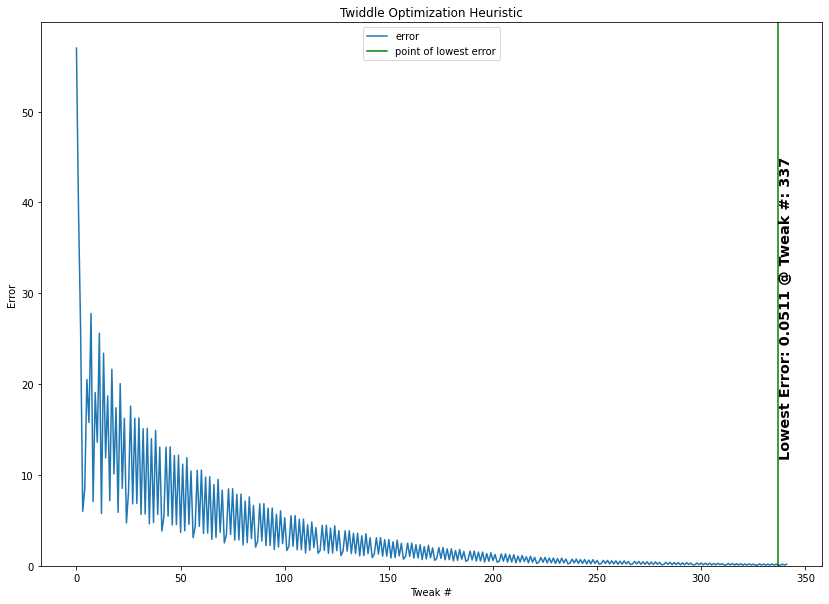


Final Params | Error: 0.17573475148113005 | Params: [37.13295498 -1.81388157] (Tweak #: 341)
Best Params | Error: 0.05105529349555127 | Params: [37.13295498 -1.77232175] (Tweak #: 337)

NOTE: Sometimes, as in this case, the best params are identified during the Twiddle heuristic rather than at the end (best params will be returned).
The probability of this happening increases as the specified threshold & initial_params increase.



In [3]:
# =============================================================================
# INSTANTIATE OPTIMIZATION VARIABLES
# =============================================================================
# Vector of initialization parameters
initial_params = [0, 0] # --> parameters a,b that we're solving for

# Vector containing any parameters that are not to be optimized
non_optimized_params = [20, 7]

# Vector of initial changes (jump distances for hill climbing) that will be applied to each respective initial parameter
# The Twiddle algorithm will modulate these respective change amounts/jump distances up and down
potential_changes = [6, 6]

# Threshold dictates the minimum granularity of parameter change that Twiddle will enforce
# Smaller thresholds push Twiddle closer to finding the truly optimal parameters; however, smaller thresholds also cause Twiddle to take longer
threshold = .1

# =============================================================================
# OPTIMIZE PARAMETERS FOR simple_func()
# =============================================================================
params = twiddle(simple_linear_func,
                 initial_params,
                 non_optimized_params,
                 potential_changes,
                 threshold,
                 verbose = True,
                 plot_err = True)

## Twiddle to Solve for Parameters a,b in a Simple Non-linear Algorithm

Initial error is: 69
   → Tweak #: 0 | Tweaking Param #: 0 | Sum PC: 12 | Error: 3 | Params: [6, 0]
   → Tweak #: 1 | Tweaking Param #: 1 | Sum PC: 12.600000000000001 | Error: 651 | Params: [6, 6]
   → Tweak #: 2 | Tweaking Param #: 1 | Sum PC: 12.600000000000001 | Error: 645 | Params: [6, -6]
   → Tweak #: 3 | Tweaking Param #: 0 | Sum PC: 12.0 | Error: 248.5200000000001 | Params: [12.600000000000001, 0]
   → Tweak #: 4 | Tweaking Param #: 0 | Sum PC: 12.0 | Error: 68.28 | Params: [-0.5999999999999996, 0]
   → Tweak #: 5 | Tweaking Param #: 1 | Sum PC: 11.34 | Error: 475.39200000000005 | Params: [6.000000000000001, 5.4]
   → Tweak #: 6 | Tweaking Param #: 1 | Sum PC: 11.34 | Error: 469.39200000000005 | Params: [6.000000000000001, -5.4]
   → Tweak #: 7 | Tweaking Param #: 0 | Sum PC: 10.8 | Error: 216.12720000000007 | Params: [11.940000000000001, 0.0]
   → Tweak #: 8 | Tweaking Param #: 0 | Sum PC: 10.8 | Error: 68.9928 | Params: [0.0600000000000005, 0.0]
   → Tweak #: 9 | Tweaking Par

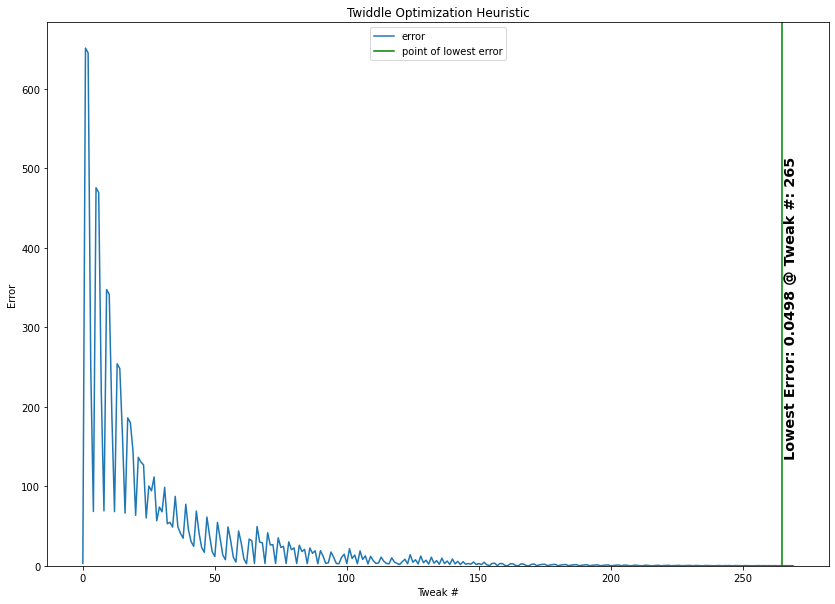


Final Params | Error: 0.07250582388898863 | Params: [ 5.87956318 -0.4128026 ] (Tweak #: 269)
Best Params | Error: 0.04982628947365697 | Params: [ 5.87956318 -0.30921991] (Tweak #: 265)

NOTE: Sometimes, as in this case, the best params are identified during the Twiddle heuristic rather than at the end (best params will be returned).
The probability of this happening increases as the specified threshold & initial_params increase.



In [4]:
# =============================================================================
# INSTANTIATE OPTIMIZATION VARIABLES
# =============================================================================
# Vector of initialization parameters
initial_params = [0, 0] # --> parameters a,b that we're solving for

# Vector containing any parameters that are not to be optimized
non_optimized_params = [20, 7]

# Vector of initial changes (jump distances for hill climbing) that will be applied to each respective initial parameter
# The Twiddle algorithm will modulate these respective change amounts/jump distances up and down
potential_changes = [6, 6]

# Threshold dictates the minimum granularity of parameter change that Twiddle will enforce
# Smaller thresholds push Twiddle closer to finding the truly optimal parameters; however, smaller thresholds also cause Twiddle to take longer
threshold = .1

# =============================================================================
# OPTIMIZE PARAMETERS FOR simple_func()
# =============================================================================
params = twiddle(simple_non_linear_func,
                 initial_params,
                 non_optimized_params,
                 potential_changes,
                 threshold,
                 verbose = True,
                 plot_err = True)

## References
- [Twiddle - CS373 Unit 5 - Udacity](https://www.youtube.com/watch?v=2uQ2BSzDvXs) **➜** Explanation of Twiddle by [Sebastian Thrun](https://en.wikipedia.org/wiki/Sebastian_Thrun)
- [Basic Twiddle Implementation in Pythonic Pseudo Code](https://martin-thoma.com/twiddle/) **➜** Provided by [Martin Toma](https://martin-thoma.com/author/martin-thoma/)